# Experiment fitting downward trend in data

Use shift in patient flows roughly from the start to end of March

In [185]:
# https://www.cs.toronto.edu/~duvenaud/cookbook/
# https://docs.gpytorch.ai/en/latest/index.html
# https://distill.pub/2019/visual-exploration-gaussian-processes/

# Modules needed
import numpy as np
import pandas as pd
import os, time
from scipy.stats import norm
from plotnine import *
import plotnine
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from funs_support import cvec

# sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, Sum, Product, RationalQuadratic
# gpytorch
import torch
import gpytorch

dir_base = os.getcwd()
dir_flow = os.path.join(dir_base,'..','output','flow')

crit = norm.ppf(1-0.05/2)
seed = 1234

## (1) Test GPs on simulated data

R-squared for df1: 0.905, df2: 0.915


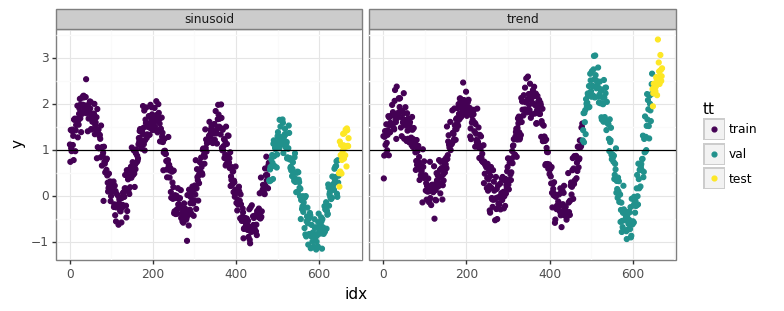

<ggplot: (8763167945201)>

In [25]:
ntrain, nval, ntest = 480, 168, 24
n = ntrain + nval + ntest
np.random.seed(seed)
# Data type 1: noisy downward sinusoid
idx1 = np.arange(n)
signal1, noise1, trend1 = np.sin(idx1/25)+1, 0.25*np.random.randn(n), np.linspace(0,-1,n)
df1 = pd.DataFrame({'idx':idx1, 'y':signal1+noise1+trend1,
                    'tt':pd.cut(idx1,bins=[0,ntrain,n-ntest,n+1],right=False,labels=['train','val','test'])})
# Data type 2: Multiplicative seansonal trend
noise2, signal2 = 0.25*np.random.randn(n), (signal1-1)*(-trend1+0.70) + 1
df2 = pd.DataFrame({'idx':idx1, 'y':signal2+noise2, 'tt':df1.tt})
df = pd.concat([df1.assign(df='sinusoid'), df2.assign(df='trend')])
print('R-squared for df1: %0.3f, df2: %0.3f' % (r2_score(signal1+trend1, df1.y), r2_score(signal2, df2.y)))

enc1, enc2 = StandardScaler(), StandardScaler()
X1_train, y1_train = enc1.fit_transform(cvec(df1[df1.tt=='train'].idx)), df1[df1.tt=='train'].y.values
X2_train, y2_train = enc2.fit_transform(cvec(df2[df2.tt=='train'].idx)), df2[df2.tt=='train'].y.values
X1_val, y1_val = enc1.fit_transform(cvec(df1[df1.tt=='val'].idx)), df1[df1.tt=='val'].y.values
X2_val, y2_val = enc2.fit_transform(cvec(df2[df2.tt=='val'].idx)), df2[df2.tt=='val'].y.values
X1_test, y1_test = enc1.transform(cvec(df1[df1.tt=='test'].idx)), df1[df1.tt=='test'].y.values
X2_test, y2_test = enc2.transform(cvec(df2[df2.tt=='test'].idx)), df2[df2.tt=='test'].y.values

plotnine.options.figure_size = (8, 3)
gg_df = (ggplot(df, aes(x='idx',y='y',color='tt')) + geom_point() + theme_bw() + 
         facet_wrap('~df') + geom_hline(yintercept=1))
gg_df

In [26]:
X1_test.shape

(24, 1)

## (1.A) sklearn

Different configurations of the hyperparameters will "fit" the training data, the goal is to tweak it on the validation set.

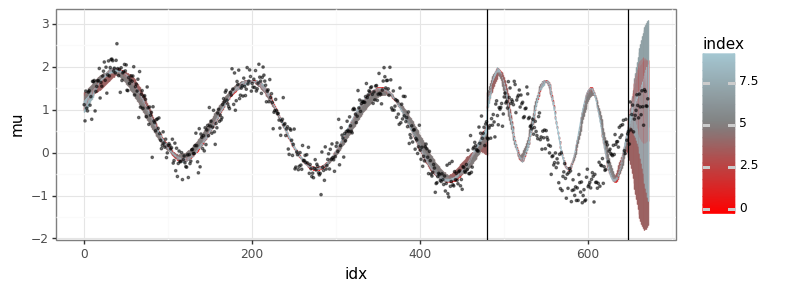

<ggplot: (8763193830593)>

In [109]:
np.random.seed(seed)
nparams = 500
ll_seq = np.linspace(0.01,10, nparams)
ll_period = np.linspace(0.01, 6, nparams)
params = pd.DataFrame({'noise1':np.linspace(0, y1_train.var(), nparams),
                       'rbf_sig2':ll_seq, 'rbf_l':ll_seq,
                       'esq_l':ll_seq, 'esq_period':ll_seq,
                       'rq_l':ll_seq, 'rq_alpha':ll_seq})

nsamp = 100
sampled = params.apply(lambda x: x.sample(nsamp).values, axis=0)
# oracle1 = pd.Series({'noise1':0.0848,'rbf_sig2':0.733,'rbf_l':3.98,'esq_l':0.889,'esq_period':2.27})
# sampled = sampled.append(oracle1,ignore_index=True)
holder, store_kern = [], []
for ii, rr in sampled.iterrows():
    kern_ii = rr.rbf_sig2**2*RBF(rr.rbf_l) + ExpSineSquared(rr.esq_l, rr.esq_period) + \
                    WhiteKernel(rr.noise1)# + RationalQuadratic(rr.rq_l, rr.rq_alpha)
    gpr_ii = GaussianProcessRegressor(kernel=kern_ii, optimizer=None, normalize_y=True).fit(X1_train, y1_train)
    mu_ii, se_ii = gpr_ii.predict(np.r_[X1_train, X1_val, X1_test], True)
    holder.append(pd.DataFrame({'mu':mu_ii,'se':se_ii,'ii':ii,'nll':-gpr_ii.log_marginal_likelihood_value_}))
    store_kern.append(kern_ii)
dat_sampled = pd.concat(holder).reset_index().rename(columns={'index':'idx'})
best_ii = dat_sampled.groupby('ii').nll.mean().reset_index().sort_values('nll').reset_index(None,True).reset_index()

tmp = best_ii.head(10).merge(dat_sampled,'inner','ii')
gg_sampled = (ggplot(tmp, aes(x='idx',y='mu',color='index')) + 
              geom_line() + theme_bw() + 
              geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
              geom_point(aes(x='idx',y='y'),color='black',data=df1,size=0.5,alpha=0.5) + 
              scale_color_gradient2(low='red',mid='grey',high='lightblue',midpoint=5))
gg_sampled

5.14**2 * RBF(length_scale=9.7) + ExpSineSquared(length_scale=0.531, periodicity=4.47) + WhiteKernel(noise_level=0.105)
1.82**2 * RBF(length_scale=0.406) + ExpSineSquared(length_scale=1.04e+03, periodicity=3.81e+04) + WhiteKernel(noise_level=0.0853)


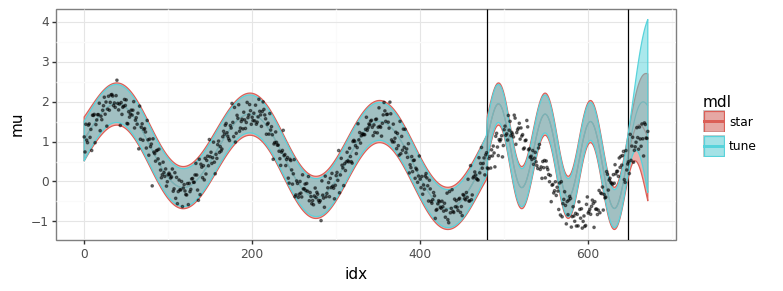

<ggplot: (8763161456721)>

In [110]:
# "Tune" parameters to the training
kern1_star = store_kern[best_ii.ii[0]]
gpr1_star = GaussianProcessRegressor(kernel=kern1_star, normalize_y=True, optimizer=None).fit(X1_train, y1_train)
gpr1_tune = GaussianProcessRegressor(kernel=kern1_star, normalize_y=True, n_restarts_optimizer=5, random_state=seed)
gpr1_tune.fit(X1_train, y1_train)
print(gpr1_star.kernel_)
print(gpr1_tune.kernel_)
mu1_star, se1_star = gpr1_star.predict(np.r_[X1_train, X1_val, X1_test], True)
mu1_tune, se1_tune = gpr1_tune.predict(np.r_[X1_train, X1_val, X1_test], True)
res1 = pd.concat([pd.DataFrame({'mu':mu1_star,'se':se1_star,'mdl':'star'}),
                  pd.DataFrame({'mu':mu1_tune,'se':se1_tune,'mdl':'tune'})])
res1 = res1.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se).reset_index().rename(columns={'index':'idx'})

gg_res1 = (ggplot(res1, aes(x='idx',y='mu',color='mdl')) + theme_bw() + 
           geom_line() + geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           geom_ribbon(aes(ymin='lb',ymax='ub',fill='mdl'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=df1,size=0.5,alpha=0.5))
gg_res1

In [184]:
# Make sure we can replicate how its making its predictions
xstar = X1_test[[20]]
K = gpr1_star.kernel_(gpr1_star.X_train_)
K = gpr1_star.L_.dot(gpr1_star.L_.T)
Kinv = np.linalg.inv(K + np.diag(np.repeat(gpr1_star.alpha,ntrain)))
kstar = np.atleast_2d(gpr1_star.kernel_(xstar, gpr1_star.X_train_))
print(kstar.dot(Kinv).dot(gpr1_star.y_train_ * gpr1_star._y_train_std + gpr1_star._y_train_mean))
# Note that Kinv * ytrain = alpha_
print(kstar.dot(gpr1_star.alpha_) * gpr1_star._y_train_std + gpr1_star._y_train_mean)
print(gpr1_star.predict(xstar))

[1.24582602]
[1.25234581]
[1.25234581]


## (2) GPyTorch

In [637]:
# gpytorch has five components to model building
# 1) GP model: gpytorch.models.exactGP, 2) gpytorch.likelihoods, 3) means, 4) Kernels, 5) Distribution

class gp(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(gp, self).__init__(train_x, train_y, likelihood)
        self.mean = ConstantMean()
        self.covar = ScaleKernel(RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.covar(x)
        out = MultivariateNormal(mean_x, covar_x)
        return out
    
Xtens1_train = torch.tensor(X1_train)
Xtens1_val = torch.tensor(X1_val)
Xtens1_trainval = torch.tensor(np.r_[X1_train, X1_val])
Xtens1_trainvaltest = torch.tensor(np.r_[X1_train, X1_val, X1_test])
ytens1_train = torch.tensor(y1_train)
ytens1_val = torch.tensor(y1_val)
ytens1_trainval = torch.cat([ytens1_train, ytens1_val])
ytens1_trainvaltest = torch.cat([ytens1_trainval, torch.tensor(y1_test)])
    
ll = GaussianLikelihood()
mdl = gp(train_x=Xtens1_trainval, train_y=ytens1_trainval, likelihood=ll)
optimizer = torch.optim.Adam(params=mdl.parameters(), lr=0.01)
# marginal likelihood
mll = ExactMarginalLogLikelihood(ll, mdl)

import warnings
warnings.filterwarnings('ignore')

niter = 250
mdl.train()  # Set model to training mode
ll.train()
mat_loss = np.zeros([niter, 2])
for i in range(niter):
    optimizer.zero_grad()  # Zero gradients from previous iteration
    output = mdl(Xtens1_trainval)  # Output from model
    loss = -mll(output, ytens1_trainval) # Calc loss and backprop gradients
#     with torch.no_grad():
#         mdl.eval()
#         loss_val = -mll(mdl.forward(Xtens1_val), ytens1_val)
#         r2_train, r2_val = r2_score(ytens1_train, t2n(ll(mdl(Xtens1_train)).mean)), \
#                            r2_score(ytens1_val, t2n(ll(mdl(Xtens1_val)).mean))
#         mat_loss[i] = [r2_train, r2_val]
#         mdl.train()
    loss.backward()
    if (i + 1) % 25 == 0:
        print('Iter %d/%d - Loss: %.3f, lengthscale: %.3f, sig2: %.3f, noise: %.3f' % 
              (i + 1, niter, loss.item(), mdl.covar.base_kernel.lengthscale.item(),
               mdl.covar.base_kernel.raw_lengthscale.item(), mdl.likelihood.noise.item()))
    optimizer.step()
warnings.resetwarnings()

# tmp = pd.DataFrame(mat_loss,columns=['train','val']).rename_axis('idx').reset_index().melt('idx',None,'tt')
# tmp.head()
# gg_loss = (ggplot(tmp, aes(x='idx',y='value',color='tt')) + geom_point() + theme_bw())
# gg_loss

Iter 25/250 - Loss: 0.984, lengthscale: 0.578, sig2: -0.246, noise: 0.579
Iter 50/250 - Loss: 0.903, lengthscale: 0.487, sig2: -0.467, noise: 0.474
Iter 75/250 - Loss: 0.867, lengthscale: 0.443, sig2: -0.584, noise: 0.394
Iter 100/250 - Loss: 0.851, lengthscale: 0.422, sig2: -0.643, noise: 0.341
Iter 125/250 - Loss: 0.846, lengthscale: 0.410, sig2: -0.679, noise: 0.312
Iter 150/250 - Loss: 0.845, lengthscale: 0.402, sig2: -0.702, noise: 0.299
Iter 175/250 - Loss: 0.845, lengthscale: 0.397, sig2: -0.718, noise: 0.294
Iter 200/250 - Loss: 0.845, lengthscale: 0.393, sig2: -0.730, noise: 0.294
Iter 225/250 - Loss: 0.845, lengthscale: 0.391, sig2: -0.738, noise: 0.294
Iter 250/250 - Loss: 0.845, lengthscale: 0.389, sig2: -0.744, noise: 0.294


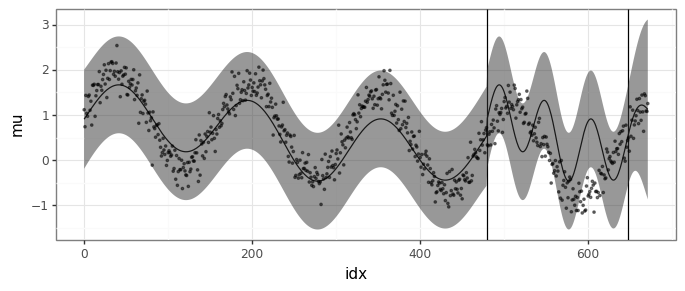

<ggplot: (8763159371869)>

In [638]:
mdl.eval()
ll.eval()
with torch.no_grad():
    tens = torch.tensor(np.r_[X1_train, X1_val, X1_test])
    pred = ll(mdl(tens))

res_torch = pd.DataFrame({'mu':t2n(pred.mean),'se':t2n(pred.stddev)}).rename_axis('idx').reset_index()
res_torch = res_torch.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)

gg_torch= (ggplot(res_torch, aes(x='idx',y='mu')) + 
           theme_bw() + geom_line() +  
           geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           geom_ribbon(aes(ymin='lb',ymax='ub'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=df1,size=0.5,alpha=0.5))
gg_torch

In [639]:
for param_name, param in mdl.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

mdl.set_train_data(inputs=Xtens1_val, targets=ytens1_val, strict=False)

Parameter name: likelihood.noise_covar.raw_noise           value = -1.0738205909729004
Parameter name: mean.constant                              value = 0.5598880648612976
Parameter name: covar.raw_outputscale                      value = 0.7040454745292664
Parameter name: covar.base_kernel.raw_lengthscale          value = -0.7445201277732849


In [640]:
## !! TRY TO TUNE ON THE VALIDATION SET !! ## 
mdl.train()  # Set model to training mode
ll.train()
optimizer = torch.optim.Adam(params=mdl.parameters(), lr=0.1)
ntweak = 100
mat, tweak = np.zeros([ntweak, 2]), []
for i in range(ntweak):
    mdl.train()
    optimizer.zero_grad()  # Zero gradients from previous iteration
    output = mdl(Xtens1_val)  # Output from model
    loss = -mll(output, ytens1_val)  # Calc loss and backprop gradients
    loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print(i + 1)
        with torch.no_grad():
            pred = ll(mdl.eval()(Xtens1_trainvaltest))
            tmp = pd.DataFrame({'mu':t2n(pred.mean),'se':t2n(pred.stddev), 'ii':i}).rename_axis('idx').reset_index()
            tweak.append(tmp)
            print('Iter %d/%d - Loss: %.3f, lengthscale: %.3f, sig2: %.3f, noise: %.3f' % 
              (i + 1, niter, loss.item(), mdl.covar.base_kernel.lengthscale.item(),
               mdl.covar.base_kernel.raw_lengthscale.item(), mdl.likelihood.noise.item()))
res_tweak = pd.concat(tweak).assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)

10
Iter 10/250 - Loss: 0.196, lengthscale: 0.779, sig2: 0.165, noise: 0.119
20
Iter 20/250 - Loss: 0.056, lengthscale: 0.775, sig2: 0.158, noise: 0.053
30
Iter 30/250 - Loss: 0.072, lengthscale: 0.641, sig2: -0.106, noise: 0.042
40
Iter 40/250 - Loss: 0.052, lengthscale: 0.737, sig2: 0.086, noise: 0.054
50
Iter 50/250 - Loss: 0.054, lengthscale: 0.672, sig2: -0.042, noise: 0.059
60
Iter 60/250 - Loss: 0.051, lengthscale: 0.697, sig2: 0.007, noise: 0.053
70
Iter 70/250 - Loss: 0.052, lengthscale: 0.680, sig2: -0.027, noise: 0.052
80
Iter 80/250 - Loss: 0.051, lengthscale: 0.692, sig2: -0.002, noise: 0.054
90
Iter 90/250 - Loss: 0.051, lengthscale: 0.686, sig2: -0.013, noise: 0.054
100
Iter 100/250 - Loss: 0.051, lengthscale: 0.691, sig2: -0.005, noise: 0.053


/home/edrysdale/miniconda3/envs/CensusFlow/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_color_gradient could not recognise parameter `midpoint`


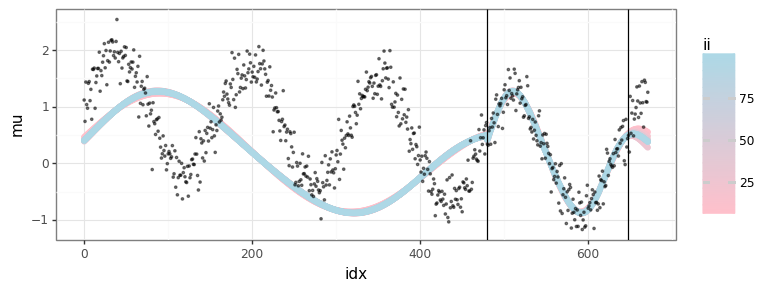

<ggplot: (8763140762605)>

In [641]:
gg_tweak =(ggplot(res_tweak, aes(x='idx',y='mu',color='ii')) + 
           theme_bw() + geom_point() + 
           geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           scale_color_gradient(low='pink',high='lightblue',midpoint=50) + 
           geom_point(aes(x='idx',y='y'),data=df1,size=0.5,alpha=0.5,color='black'))
gg_tweak

In [ ]:
# kern1a = WhiteKernel(noise_level=1)
# kern1b = 1**2*RBF(length_scale=1)
# kern1c = ExpSineSquared(length_scale=1, periodicity=25)
kern1a = WhiteKernel(noise_level=0.5)
kern1b = 2**2*RBF(length_scale=3)
kern1c = ExpSineSquared(length_scale=3, periodicity=3)

# kern1a = WhiteKernel(noise_level=0.0854)
# kern1b = 1.34**2*RBF(length_scale=7.33)
# kern1c = 1**2*ExpSineSquared(length_scale=2.19, periodicity=1.13)
kern1 = Sum(Sum(kern1c, kern1b), kern1)

gpr1 = GaussianProcessRegressor(kernel=kern1, n_restarts_optimizer=3, normalize_y=True, random_state=1234)
print(gpr1.kernel)
gpr1.fit(X1_train, y1_train)
print(gpr1.kernel_)

mu1_train, se1_train = gpr1.predict(X1_train,True)
mu1_test, se1_test = gpr1.predict(X1_test,True)
tmp1 = pd.DataFrame({'mu':np.append(mu1_train, mu1_test), 'se':np.append(se1_train, se1_test)}).reset_index()
tmp1 = tmp1.rename(columns={'index':'idx'}).assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)
# tmp1 = tmp1.melt(['tt','idx','lb','ub'],['y','mu'],'resp','val')

plotnine.options.figure_size = (6, 3)
gg1 = (ggplot(tmp1, aes(x='idx', y='mu')) + theme_bw() +
         geom_line(alpha=0.5) + geom_point(size=1, color='blue') +
         geom_vline(xintercept=ntrain) + 
         geom_point(aes(x='idx',y='y'),data=df1,color='black',alpha=0.5,size=0.6) + 
         geom_ribbon(aes(ymin='lb',ymax='ub'),color='black',fill='blue',alpha=0.2))
gg1

## (2) Use actual data

In [ ]:
dat = pd.read_csv(os.path.join(dir_flow,'test.csv')).rename(columns={'index':'idx'})
dat['tt'] = np.where(dat.tt=='train','train','test')
thresh1 = dat[dat.tt=='train'].idx.max() + 1
thresh2 = dat.idx.max() + 1

y_train = dat[dat.tt == 'train'].y.values
y_test = dat[dat.tt != 'train'].y.values
x_train = dat[dat.tt == 'train'][['idx','hour']].values
x_test = dat[dat.tt != 'train'][['idx','hour']].values
x_extra = np.c_[thresh2 + np.arange(480),np.tile(np.arange(24), 20)]
enc = StandardScaler().fit(x_train)
x_train_til, x_test_til, x_extra_til = enc.transform(x_train), enc.transform(x_test), enc.transform(x_extra)

In [ ]:
plotnine.options.figure_size = (6, 4)
gg_dat = (ggplot(dat, aes(x='idx', y='y',color='tt')) + 
          geom_point(size=1) + geom_line(size=0.5,alpha=0.5) + theme_bw() + 
          ggtitle('Downward trend in data?') + 
          geom_vline(xintercept=thresh1))
gg_dat

In [ ]:
df_hourly = dat.groupby('hour').y.describe().reset_index()
plotnine.options.figure_size = (4, 3)
gg_hourly = (ggplot(df_hourly, aes(x='hour', y='50%')) + 
             geom_point() + theme_bw() + 
             geom_linerange(aes(ymin='25%', ymax='75%')) + 
             ggtitle('Clear hourly trend'))
gg_hourly

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression

def nadarya(x, X, y, ll=0.5):
    """
    FUNCTION TO IMPLEMENT NADARYA-WATSON LINEAR SMOOTHER
    """
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T
    ytil = np.sum((w_gauss * cvec(y)), 0) / w_gauss.sum(0)
    return ytil
    
def local_reg(x, X, y, ll=0.5):
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T.flatten()
    #endog = x - X
    mdl = LinearRegression(fit_intercept=True).fit(X, y, w_gauss)
    return mdl.predict(x)

In [ ]:
local_test = np.array([local_reg(x_test_til[[z]], x_train_til, y_train, ll=1) for z in range(x_test.shape[0])])
local_extra = np.array([local_reg(x_extra_til[[z]], x_train_til, y_train, ll=1) for z in range(x_extra.shape[0])])
qq = pd.DataFrame({'idx':np.append(x_test[:,0],x_extra[:,0]),'est':np.append(local_test, local_extra)})
gg_local = (ggplot(qq, aes(x='idx',y='est')) + theme_bw() +
            geom_point(size=0.5) + geom_line(size=0.5, alpha=0.5) + 
            geom_vline(xintercept=thresh2,color='blue'))
gg_local

In [ ]:
smooth1 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=0.5)
smooth2 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=2.5)
tmp = dat.assign(smooth1=smooth1, smooth2=smooth2).melt(['idx','y','tt'],
                    ['smooth1','smooth2'],'smooth').assign(res=lambda x: x.y - x.value)

plotnine.options.figure_size = (6, 4)
gg_dat = (ggplot(tmp, aes(x='idx', y='y')) + 
          geom_point(size=1) + geom_line(size=0.5,alpha=0.5) + theme_bw() + 
          ggtitle('Downward trend in data?') + 
          geom_line(aes(x='idx',y='value',color='smooth'),data=tmp) + 
          geom_vline(xintercept=thresh1))
gg_dat

In [ ]:
smooth3 = nadarya(np.vstack([x_test_til, x_extra_til]), x_train_til, y_train, ll=0.50)
tmp2 = pd.DataFrame({'idx':np.r_[x_test[:,0],x_extra[:,0]],'pred':smooth3})
plotnine.options.figure_size = (6, 4)
gg_cont = (ggplot(tmp2, aes(x='idx',y='pred')) + geom_point() + 
           theme_bw() + geom_line() + 
           geom_vline(xintercept=thresh2))
gg_cont